# Telling a Story Using Data- A Robot-Run Cafe  

## Project description
This project's aim was to assist decision makers regarding the opening of a small robot-run cafe in Los Angeles, by preparing market research. In order to attract investors, we are interested in providing a clear picture about the current market conditions- specifically: The distribution of foodservice shops across different types of foodservices, as well as across different streets in the city. Also, we would like to know more about the distribution of chain and non-chain shops, and the number of seats in each establishment. 
Relevant data was extracted from open-source data on restaurants in LA.

## Step 1. Download the data and prepare it for analysis

In [1]:
 pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install usaddress

In [3]:
pip install sidetable

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly-express

In [5]:
import pandas as pd
import numpy as np
import sidetable
import usaddress
import re
import matplotlib.pyplot as plt
from scipy import stats as st
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
import math as mth
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [6]:
try:
    rest = pd.read_csv(r"C:\Users\USER\OneDrive\מסמכים\DATA ANALYST\Practicum100\How to tell a story using data\story telling project\rest_data_us.csv", sep=',')
    
except:
    rest = pd.read_csv("/datasets/rest_data_us.csv", sep=',')

In [7]:
rest.sample(10)
rest.info()

,id,object_name,address,chain,object_type,number
9636,21422,CHIPOTLE #3094,6719 LA TIJERA BLVD # A-B,True,Restaurant,47
8846,20632,POLLOS AL CARBON RESTAURANT,326 E PICO BLVD,True,Restaurant,12
4769,16555,ROCK AND BREWS CONCERT BAR,500 WORLD WAY #5J,True,Bar,69
3288,15074,LAUNDRY ZONE,3278 W PICO BLVD,False,Restaurant,13
3864,15650,ERIK'S 4 VIENTOS #2,1412 S LORENA ST,False,Restaurant,147
2311,14097,BLUE COW CAFE,350 S GRAND AVE STE R-3,False,Restaurant,62
4114,15900,KREATION ABBOT,1202 ABBOT KINNEY BLVD,False,Restaurant,62
4059,15845,TOUS LES JOURS,450 S WESTERN AVE # 103,True,Restaurant,12
4028,15814,EMILIA'S FASTFOOD,4433 S ALAMEDA ST # D-55,True,Restaurant,16
8175,19961,COFFEE BEAN AND TEA LEAF,500 WORLD WAY,True,Cafe,29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


A few remarks:
- Looks like there are 3 missing values in "chain". It is 0.03% of data, so can be dropped.
- I would change the data type of "chain" to boolean and of "object_type" to category.

#### # Dropping missing values:

In [8]:
# dropping rows with missing values:
rest=rest.dropna()


#### # Converting data types:

In [9]:
# changing dtypes:
rest['chain'] = rest['chain'].astype('bool')
rest['object_type'] = rest['object_type'].astype('category')
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9648 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           9648 non-null   int64   
 1   object_name  9648 non-null   object  
 2   address      9648 non-null   object  
 3   chain        9648 non-null   bool    
 4   object_type  9648 non-null   category
 5   number       9648 non-null   int64   
dtypes: bool(1), category(1), int64(2), object(2)
memory usage: 395.9+ KB


#### # Checking for duplicates in the whole dataframe and in object_name column:

In [10]:
# checking for duplicates: (none)
rest.duplicated().sum()

0

In [11]:
# checking for optional duplications in the object_names of establishments belonging to the same chain-
chains = rest.query('chain == True')[['object_name', 'object_type', 'number', 'id']]
chains.sort_values(by='object_name', ascending=False)


,object_name,object_type,number,id
8171,ZIP SUSHI & IZAKAYA,Restaurant,98,19957
4373,ZION MARKET DELI & ISLAND,Restaurant,16,16159
1616,ZERMENOS RESTAURANT INC,Restaurant,10,13402
6021,ZEN BAKERY (RETAIL),Bakery,19,17807
8509,ZANKOU CHICKEN,Restaurant,67,20295
...,...,...,...,...
6180,4 CAMINOS RESTAURANT,Restaurant,18,17966
6548,3RD ST MARKET & DELI,Restaurant,7,18334
1445,333,Restaurant,180,13231
5614,1810 RESTAURANT,Restaurant,45,17400


* There are 3676 foodservice places that are part of a foodserice chain. This table shows that chain establishments (sometimes) have the same name. In order to know the true number of establishments per chain we have to add them up by name.

In [12]:
chains.groupby('object_name')['id'].count().sort_values().reset_index()

,object_name,id
0,#1 CHINESE FAST FOOD,1
1,PANDA EXPRESS #792,1
2,PANDA EXPRESS #948,1
3,PANDA EXPRESS 2919,1
4,PANDA EXPRESS INC.,1
...,...,...
2728,KENTUCKY FRIED CHICKEN,14
2729,WABA GRILL,14
2730,DOMINO'S PIZZA,15
2731,SUBWAY,31


* When grouped by name we get 2733 records, but as can be seen, the establishment names ('object_name') are misleading: "Panda Express", for example, appears as different names although they belong to the same chain. We should join them together. 

In [13]:
# A function to eliminate numbers and '#':
def clean_up(name):
    name= re.sub(' [^A-Za-z]+', '', name)
    return name

In [14]:
# an example- trying the function on one name:
clean_up('PANDA EXPRESS #792')

'PANDA EXPRESS'

In [15]:
# calling the function to work on the column:
chains['clean_name'] = chains['object_name'].apply(clean_up)

In [16]:
#checking:
chains.groupby('clean_name')['id'].count().reset_index().value_counts()

clean_name                           id
#1 CHINESE FAST FOOD                 1     1
PALM TREE LA                         2     1
PAPILLON INTERNATIONAL BAKERY        1     1
PAPA JOHNS PIZZA                     2     1
PAPA JOHN'S PIZZA                    14    1
                                          ..
HAESHIN RESTAURANT                   1     1
HAE JANG CHON KOREAN BBQ RESTAURANT  1     1
HABAYIT RESTAURANT                   1     1
GUSTO                                2     1
ZIP SUSHIIZAKAYA                     1     1
Length: 2071, dtype: int64

**Now there are 2071 records of names 

#### # General descriptive statistics: 

In [17]:
# Looking deeper into the data:
rest.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,9648.0,NaN,NaN,NaN,16610.056385,2786.049701,11786.0,14197.75,16609.5,19021.25,21436.0
object_name,9648,8669,THE COFFEE BEAN & TEA LEAF,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
address,9648,8514,3607 TROUSDALE PKWY,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chain,9648,2,False,5972,NaN,NaN,NaN,NaN,NaN,NaN,NaN
object_type,9648,6,Restaurant,7253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number,9648.0,NaN,NaN,NaN,43.703566,47.627252,1.0,14.0,27.0,46.0,229.0


**A few remarks:**
- The most popular object_name is THE COFFEE BEAN & TEA LEAF (47 times)- probably a chain
- The most popular adress is: 3607 TROUSDALE PKWY (11 times)
- The most popular object_type is a Restaurant (7253 out of 9648= 75.18%)
- The average number of seats is 43.70, but with a very wide variance, and a much lower median, so maybe median or mode would be a better measure.
- Also, the minimum number of seats is 1- would be good to look into this number and understand where and how many times it is registered.


In [18]:
rest[rest['number'] == 1]

,id,object_name,address,chain,object_type,number
8,11794,ABC DONUTS,3027 N SAN FERNANDO RD UNIT 103,True,Fast Food,1
35,11821,REGGIE'S DELI & CAFE,1910 W SUNSET BLVD STE 150,True,Restaurant,1
93,11879,TACOMIENDO,11462 GATEWAY BLVD,False,Fast Food,1
139,11925,KIKKA SUSHI,308 WESTWOOD PLZ # A233B,True,Restaurant,1
265,12051,LUCKY STRIKE HOLLYWOOD,6801 HOLLYWOOD BLVD STE #143,False,Restaurant,1
...,...,...,...,...,...,...
9562,21348,7-ELEVEN STORE #18778D,7600 W SUNSET BLVD,False,Restaurant,1
9566,21352,THE BUTLER'S KITCHEN,5616 E BEVERLY BLVD,False,Restaurant,1
9589,21375,WHITE AND BROWN,603 S MARIPOSA AVE,False,Restaurant,1
9600,21386,YAKITORI TEN,3470 W 6TH ST STE 2A,False,Restaurant,1


There are 186 businesses that allow only one seated customer(maybe a take away place..?), and they are from all types of object_type and chain.

## Step 2. Data analysis

### 2.1. Investigate the proportions of the various types of establishments. Plot a graph.

In [19]:
type_des = rest.stb.freq(['object_type']).sort_values(by='percent', ascending=False)
type_des

,object_type,count,percent,cumulative_count,cumulative_percent
0,Restaurant,7253,75.176202,7253,75.176202
1,Fast Food,1066,11.048922,8319,86.225124
2,Cafe,435,4.508706,8754,90.733831
3,Pizza,319,3.306385,9073,94.040216
4,Bar,292,3.026534,9365,97.066750
5,Bakery,283,2.933250,9648,100.000000


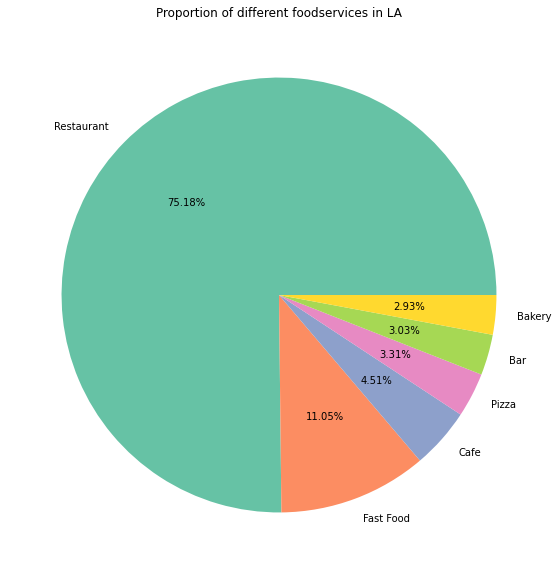

In [20]:
#define data
values = type_des['percent']
labels = type_des['object_type']

#define Seaborn color palette to use
colors = sns.color_palette('Set2')[0:6]

#create pie chart
plt.figure(figsize=(14, 10))
plt.pie(values, labels = labels, colors = colors, autopct='%.2f%%')
plt.title("Proportion of different foodservices in LA")
plt.show();


### 2.2 - Investigate the proportions of chain and nonchain establishments. Plot a graph.

In [21]:
type_chain = rest.stb.freq(['chain'])
type_chain

,chain,count,percent,cumulative_count,cumulative_percent
0,False,5972,61.898839,5972,61.898839
1,True,3676,38.101161,9648,100.000000


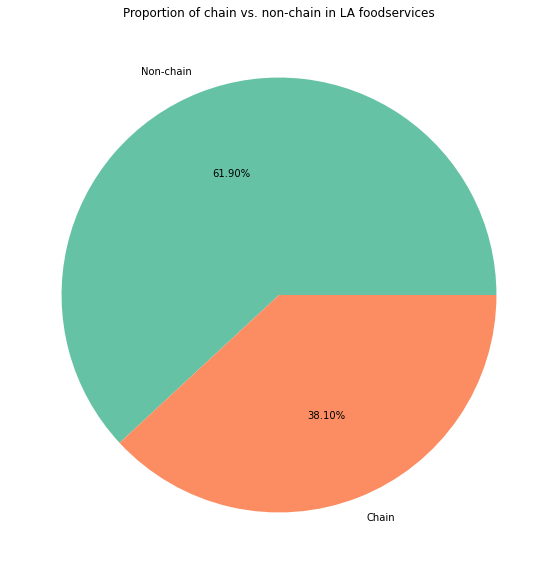

In [22]:
#define data
values = type_chain['percent']
labels = ['Non-chain', 'Chain']

#define Seaborn color palette to use
colors = sns.color_palette('Set2')

#create pie chart
plt.figure(figsize=(14, 10))
plt.pie(values, labels = labels, colors = colors, autopct='%.2f%%')
plt.title("Proportion of chain vs. non-chain in LA foodservices")
plt.show();

### 2.3 - Which type of establishment is typically a chain?


In [23]:
# creating dataset:
chain_p_type = rest.groupby(['object_type', 'chain'])['chain'].agg(['count']).reset_index()
chain_p_type= chain_p_type.rename(columns={"count": "shop_count"})

# creating a percent column:
chain_p_type['chain_percent_type'] = 100* (round(chain_p_type['shop_count']/ chain_p_type.groupby('object_type')['shop_count'].transform('sum'), 2))
chain_p_type


,object_type,chain,shop_count,chain_percent_type
0,Bakery,False,0,0.0
1,Bakery,True,283,100.0
2,Bar,False,215,74.0
3,Bar,True,77,26.0
4,Cafe,False,169,39.0
5,Cafe,True,266,61.0
6,Fast Food,False,461,43.0
7,Fast Food,True,605,57.0
8,Pizza,False,166,52.0
9,Pizza,True,153,48.0


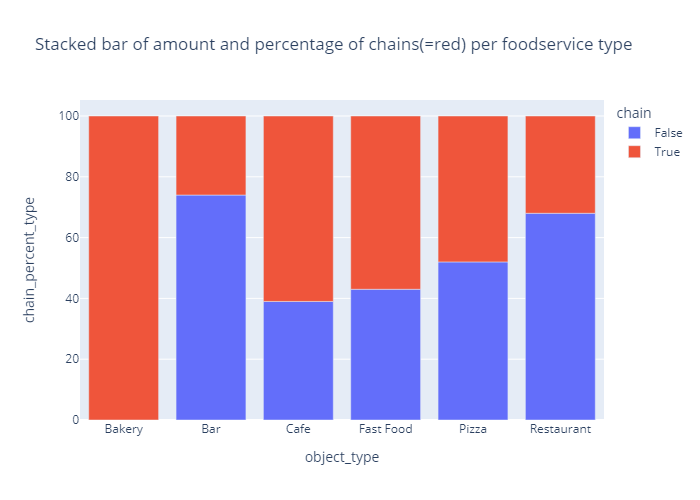

In [24]:
# creating a stacked bar graph of the number of chains per foodservice type:
fig = px.bar(chain_p_type, x="object_type", y="chain_percent_type", color="chain", 
             # text_auto=True, ## COMMENTEED BY REVIEWER
             title= "Stacked bar of amount and percentage of chains(=red) per foodservice type",
             hover_data=['shop_count'])
fig.show("png");


**Summary: Which type of establishment is typically a chain?**
- Although the vast magority of establishments are restaurants, only 32% of them are part of a chain. 
- Cafe shops, however, as well as Fast food joints, are more often part of a chain (61% and 57%, respectively).
- All bakeries registered in LA (283) belong to chains.
- Bars and Pizza joints had a higher frequency of non-chain establishment (74% and 52% non chains, respectively).

### 2.4 What characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?

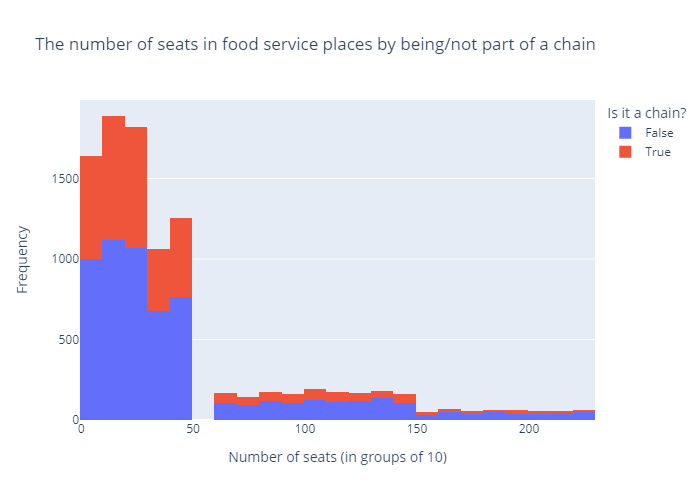

In [25]:
# histograms of the number of seats in establishments, according to if it is/not part of a chain:
fig= px.histogram(rest, x='number', color='chain', nbins=40, title='The number of seats in food service places by being/not part of a chain')
fig.update_layout(
    xaxis_title="Number of seats (in groups of 10)",
    yaxis_title="Frequency",
    legend_title="Is it a chain?")
fig.show("png");

In [26]:
# calculating general mean and median:
print("The average number of seats according to chain/ non-chain businesses:")
rest.groupby('chain')['number'].mean()
print()
print("The median of the number of seats according to chain/ non-chain businesses:")
rest.groupby('chain')['number'].median()

The average number of seats according to chain/ non-chain businesses:


chain
False    46.171467
True     39.694233
Name: number, dtype: float64


The median of the number of seats according to chain/ non-chain businesses:


chain
False    28.0
True     25.0
Name: number, dtype: float64

**- The histogram and calculations shows that foodservices that are part of chains tend to offer LESS seating options to their customers, compared to non-chains.** 
- For example, in the category of businesses that offer between 10-19 seats, there are 1121 non-chain businesses and only 767 chain businesses. 


In [27]:
id_b_chain=rest.groupby('chain')['id'].count().reset_index().rename(columns={"id": "est_num"})
id_b_chain

,chain,est_num
0,False,5972
1,True,3676


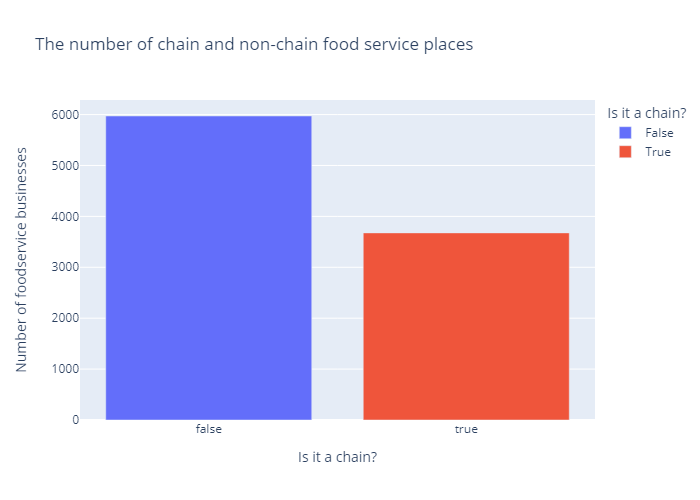

In [28]:
# histograms of the number of seats in establishments, according to if it is/not part of a chain:
fig= px.bar(id_b_chain, x='chain', y='est_num',
            title='The number of chain and non-chain food service places',
           color='chain')
fig.update_layout(
    xaxis_title="Is it a chain?",
    yaxis_title="Number of foodservice businesses",
    legend_title="Is it a chain?")

fig.show("png");


**Summary- Chain foodservice businesses tend to have less shops in LA (3676) and to offer less seating optiona, compared with businesses that were not part of a chain. (yet, i haven't checked for statistical significance)** 

In [29]:
# A reminder of the relevant subset of data:
chains.head(3)

,object_name,object_type,number,id,clean_name
8,ABC DONUTS,Fast Food,1,11794,ABC DONUTS
10,EL POLLO LOCO,Restaurant,38,11796,EL POLLO LOCO
11,POONG NYUN BAKERY,Bakery,17,11797,POONG NYUN BAKERY


In [30]:
# calculating the number of shops per chain and average seats:
chains_scatter = chains[['clean_name', 'number', 'id']].groupby('clean_name').agg({'id':'count', 'number':'mean'}).reset_index()
chains_scatter = chains_scatter.rename(columns={'id':'shops_per_chain', 'number': 'seats_avg'})

In [31]:
# checking if it worked:
chains_scatter.query('clean_name == "PANDA EXPRESS"')

,clean_name,shops_per_chain,seats_avg
1376,PANDA EXPRESS,23,36.043478


In [32]:
# trying to identify additional similar names that the function missed, but belong to the same chain:
chains_scatter.head(60)
chains_scatter.tail(60)

,clean_name,shops_per_chain,seats_avg
0,#1 CHINESE FAST FOOD,1,6.0
1,1810 RESTAURANT,1,45.0
2,333,1,180.0
3,3RD ST MARKETDELI,1,7.0
4,4 CAMINOS RESTAURANT,1,18.0
5,5 LINE RESTAURANT,1,41.0
6,5684 YORK RESTAURANT,1,115.0
7,85 C BAKERY CAFE,1,45.0
8,85 CELSIUS BAKERY CAFE,1,37.0
9,A MI JAPANESE RESTAURANT,1,204.0


,clean_name,shops_per_chain,seats_avg
2011,WOO REE RESTAURANT,1,14.000000
2012,WOOL UM MA RESTAURANT,1,27.000000
2013,WORLD SEAFOOD,1,29.000000
2014,WOW BOWL RESTAURANT,1,43.000000
2015,XIAOYAO INC,1,43.000000
2016,YABU RESTAURANT,1,33.000000
2017,YAI THAI FOOD,1,22.000000
2018,YAKI CAFE,2,10.000000
2019,YAMAKASE,3,12.333333
2020,YAMATO RESTAURANT,1,177.000000


In [33]:
#YUM YUM DONUTS
chains_scatter[chains_scatter['clean_name'].str.contains("YUM YUM DONUTS")]

,clean_name,shops_per_chain,seats_avg
2051,YUM YUM DONUTS,4,18.5
2052,YUM YUM DONUTS FRANCHISE,2,10.5
2053,YUM YUM DONUTS FRANCHISEE,1,6.0
2054,YUM YUM DONUTSB,1,26.0
2055,YUM YUM DONUTSC FRANCHISE,1,22.0
2056,YUM YUM DONUTSD,2,20.5
2057,YUM YUM DONUTSE,2,20.0
2058,YUM YUM DONUTSP,1,2.0
2059,YUM YUM DONUTSSTORAGE,1,5.0


In [34]:
# tried random common names (PIZZA, SUSHI, JUICE, BAKERY.. there must be a more elegant way..)
chains_scatter[chains_scatter['clean_name'].str.contains("PRETZEL")]

,clean_name,shops_per_chain,seats_avg
88,AUNTIE ANNE'S PRETZEL,2,20.000000
1990,WETZEL'S PRETZELS,6,14.666667
1991,WETZELS PRETZEL'S,1,4.000000
1992,WETZELS PRETZELS,4,14.000000


In [35]:
#replacing a few items:
chains_scatter = chains_scatter.replace({'clean_name':{"A WON JAPANASE RESTAURANT":"A WON JAPANESE RESTAURANT",
                                                      "WETZELS PRETZEL'S": "WETZEL'S PRETZELS",
                                                      "WETZELS PRETZELS": "WETZEL'S PRETZELS"}})

In [36]:
# a few more replacements:
chains_scatter = chains_scatter.replace({'clean_name':{"YUM YUM DONUTSB":"YUM YUM DONUTS",
                                                      "YUM YUM DONUTSD": "YUM YUM DONUTS",
                                                      "YUM YUM DONUTSE": "YUM YUM DONUTS",
                                                      "YUM YUM DONUTSP": "YUM YUM DONUTS",
                                                      "YUM YUM DONUTS FRANCHISEE":"YUM YUM DONUTS FRANCHISE", 
                                                      "YUM YUM DONUTSC FRANCHISE": "YUM YUM DONUTS FRANCHISE"}})   

In [37]:
chains_scatter = chains_scatter.groupby('clean_name').agg({'shops_per_chain':'sum', 'seats_avg':'mean'}).reset_index()
chains_scatter.sort_values(by='shops_per_chain', ascending=False)

,clean_name,shops_per_chain,seats_avg
1727,SUBWAY,121,16.826446
1709,STARBUCKS COFFEE,87,24.850575
1176,MCDONALD'S,80,94.487500
789,JACK IN THE BOX,53,65.981132
1834,THE COFFEE BEANTEA LEAF,51,26.235294
...,...,...,...
785,IZAKAYA OSEN,1,46.000000
784,IVAN'S RESTAURANT,1,10.000000
783,ITS BOBA TIME,1,24.000000
782,IT'S THAI HOME RESTAURANT,1,32.000000


In [38]:
# checking:
chains_scatter[chains_scatter['clean_name'].str.contains("YUM YUM DONUTS")]

,clean_name,shops_per_chain,seats_avg
2048,YUM YUM DONUTS,10,17.400000
2049,YUM YUM DONUTS FRANCHISE,4,12.833333
2050,YUM YUM DONUTSSTORAGE,1,5.000000


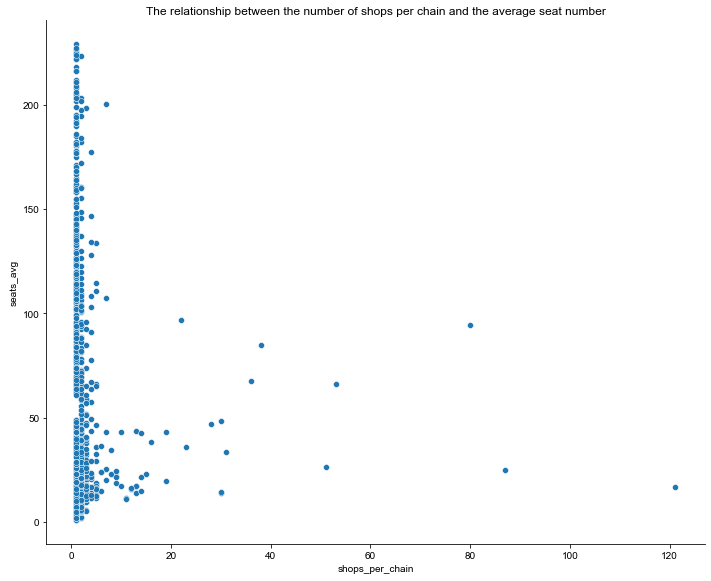

In [39]:
sns.relplot(data = chains_scatter, x="shops_per_chain", y="seats_avg",
            height = 8, aspect = 1.25).set(title= "The relationship between the number of shops per chain and the average seat number")
sns.set(style="whitegrid", font_scale=2);

In [40]:
chains_scatter.describe()

,shops_per_chain,seats_avg
count,2062.000000,2062.000000
mean,1.782735,39.816004
std,4.634463,43.760867
min,1.000000,1.000000
25%,1.000000,14.000000
50%,1.000000,24.000000
75%,1.000000,43.075000
max,121.000000,229.000000


**Within the shops that are part of chains, there doesn't seem to be a linear relation between chain size and seats. We can see that the vast majority of chains have 1 shop in LA, with a wide variety of seat number (IQR between 14 and 43 seats, but climb way beyond). Also, chains with a great number of shops don't tend to offer above 100 seats. However, since there are only a few of such chains, it would be problematic to call it a trend. 

### 2.5 Determine the average number of seats for each type of restaurant. On average, which type of restaurant has the greatest number of seats? Plot graphs.

In [41]:
seat_b_type= rest.groupby('object_type')['number'].agg('mean').reset_index().rename(
    columns={"number": "avg_seats"}).sort_values(by='avg_seats', ascending= False)

seat_b_type                         

,object_type,avg_seats
5,Restaurant,48.048807
1,Bar,44.767123
3,Fast Food,31.837711
4,Pizza,28.545455
2,Cafe,25.000000
0,Bakery,21.773852


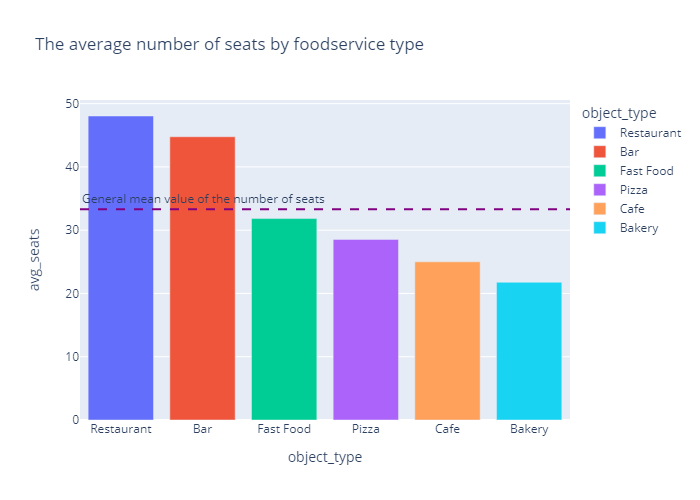

In [42]:
fig= px.bar(seat_b_type, x='object_type', y='avg_seats',
            title='The average number of seats by foodservice type',
            color='object_type')
fig.add_hline(y=seat_b_type['avg_seats'].mean(),line_dash="dash", line_color="purple", annotation_text="General mean value of the number of seats",
             annotation_position="top left")
fig.show("png");

**Summary- On average, restaurants and bars offer above average seating options, whereas Fast food, pizza joints, cafe shops and bakeries offer the smallest amount (in this order). It looks like LA has a richer night than day life, in terms of foodservices, or maybe averaging data from the whole city, masks different dynamics in different neighborhoods**

### 2.6 Put the data on street names from the address column in a separate column.

In [43]:
#loading the data again to see what format of address we have
rest.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [44]:
#creating a street example to work with:
street_example=rest.loc[0,'address']
street_example

'3708 N EAGLE ROCK BLVD'

In [45]:
# parsing it via usaddress:
raw_address = usaddress.parse(street_example)
raw_address

[('3708', 'AddressNumber'),
 ('N', 'StreetNamePreDirectional'),
 ('EAGLE', 'StreetName'),
 ('ROCK', 'StreetName'),
 ('BLVD', 'StreetNamePostType')]

In [46]:
#create a new dictionary to assist in later extracting the needed component:
dict_address={}
for i in raw_address:
    if i[1] not in dict_address.keys():
        dict_address.update({i[1]:i[0]})
    else:
        old_value = dict_address[i[1]]
        dict_address.update({i[1]:old_value+ ' ' + i[0]})
dict_address

{'AddressNumber': '3708',
 'StreetNamePreDirectional': 'N',
 'StreetName': 'EAGLE ROCK',
 'StreetNamePostType': 'BLVD'}

In [47]:
# incorporating it in a function:
# (some rows didn't have all the address info, and i got an error, so i had to expand the function to include more options)
def cleaning_add(raw):
    raw_address=usaddress.parse(raw)
    dict_address={}
    for i in raw_address:
        if i[1] not in dict_address.keys():
            dict_address.update({i[1]:i[0]})
        else:
            old_value = dict_address[i[1]]
            dict_address.update({i[1]:old_value+ ' ' + i[0]})
    if 'StreetName' in dict_address.keys() and 'StreetNamePostType' in dict_address.keys():
        street_name=str(dict_address['StreetName'])+ " "+ str(dict_address['StreetNamePostType'])
        return street_name
    elif 'StreetName' in dict_address.keys():
        street_name= str(dict_address['StreetName'])
        return street_name
    else:
        return 'no street'
    

In [48]:
# applying the function to a random set:
rest.address.head(5).apply(cleaning_add)

0    EAGLE ROCK BLVD
1          WORLD WAY
2     HOLLYWOOD BLVD
3        SUNSET BLVD
4      ECHO PARK AVE
Name: address, dtype: object

In [49]:
# applying to whole column:
rest['street_name']= rest.address.apply(cleaning_add)
rest.tail(10)

,id,object_name,address,chain,object_type,number,street_name
9641,21427,OCEAN BASKETS,2851 CRENSHAW BLVD,False,Restaurant,15,CRENSHAW BLVD
9642,21428,TOLOSA,2635 WHITTIER BLVD,False,Restaurant,19,WHITTIER BLVD
9643,21429,DIVINE DIPS,601 S LOS ANGELES ST,False,Restaurant,25,LOS ANGELES ST
9644,21430,LA BUFADORA BAR,3470 E 1ST ST,False,Bar,24,1ST ST
9645,21431,SAINT MARC,10250 SANTA MONICA BLVD # 1025,False,Restaurant,225,SANTA MONICA BLVD
9646,21432,HALL OF JUSTICE,217 W TEMPLE AVE,False,Restaurant,122,TEMPLE AVE
9647,21433,FIN-MELROSE,5750 MELROSE AVE,False,Restaurant,93,MELROSE AVE
9648,21434,JUICY WINGZ,6741 HOLLYWOOD BLVD,True,Fast Food,15,HOLLYWOOD BLVD
9649,21435,MEDIDATE COFFEE,548 S SPRING ST STE 100,False,Cafe,6,SPRING ST
9650,21436,CAFE SPROUTS,1300 S SAN PEDRO ST STE 111,True,Restaurant,19,SAN PEDRO ST


### 2.7 Plot a graph of the top ten streets by number of restaurants.

In [50]:
# calculating the number of foodservice shops per street:
top_strts= rest.groupby(
    'street_name')[['street_name','id']].agg({'id': 'count'}).reset_index().sort_values(by='id', ascending=False).head(10)
top_strts= top_strts.rename(columns={'id': 'num_streets'})
top_strts

,street_name,num_streets
475,SUNSET BLVD,403
537,WILSHIRE BLVD,397
411,PICO BLVD,370
523,WESTERN AVE,367
211,FIGUEROA ST,332
393,OLYMPIC BLVD,309
502,VERMONT AVE,286
442,SANTA MONICA BLVD,264
27,3RD ST,260
261,HOLLYWOOD BLVD,253


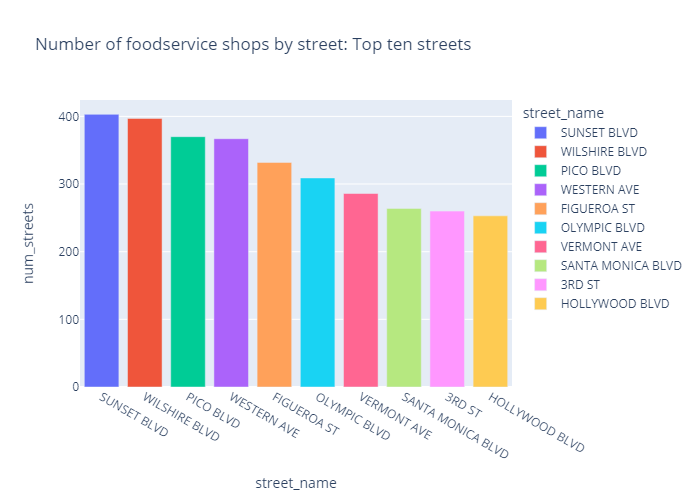

In [51]:
# A plot of the top 10 streets for foodservices:
fig= px.bar(top_strts, x='street_name', y='num_streets',
            title='Number of foodservice shops by street: Top ten streets',
            color='street_name')
fig.show("png");

**The top 10 selling streets in LA hold between 253 and 403 foodservice shops. Many of them are long Blvd, or Ave.

### 2.8 Find the number of streets that only have one restaurant.

In [52]:
rest_p_strt= rest.groupby(
    'street_name')[['street_name','id']].agg({'id': 'count'}).reset_index().rename(columns={'id': 'num_strts'})
one_rest = rest_p_strt.query('num_strts == 1')
print("There are {} streets that have only ONE foodservice shop".format(len(one_rest)))

There are 250 streets that have only ONE foodservice shop


### 2.9 For streets with a lot of restaurants, look at the distribution of the number of seats. What trends can you see?

In [53]:
# choosing top 10 streets, and turning them to a list:
list_top10 = top_strts.street_name.to_list()
list_top10

['SUNSET BLVD',
 'WILSHIRE BLVD',
 'PICO BLVD',
 'WESTERN AVE',
 'FIGUEROA ST',
 'OLYMPIC BLVD',
 'VERMONT AVE',
 'SANTA MONICA BLVD',
 '3RD ST',
 'HOLLYWOOD BLVD']

In [54]:
# creating a dataset of these streets and descriptive statistics as well:
df_top10 = rest.query('street_name in @list_top10')
df_top10.describe()


,id,number
count,3241.000000,3241.000000
mean,16563.081765,45.616168
std,2781.059645,48.026338
min,11788.000000,1.000000
25%,14125.000000,15.000000
50%,16451.000000,29.000000
75%,19017.000000,47.000000
max,21434.000000,229.000000


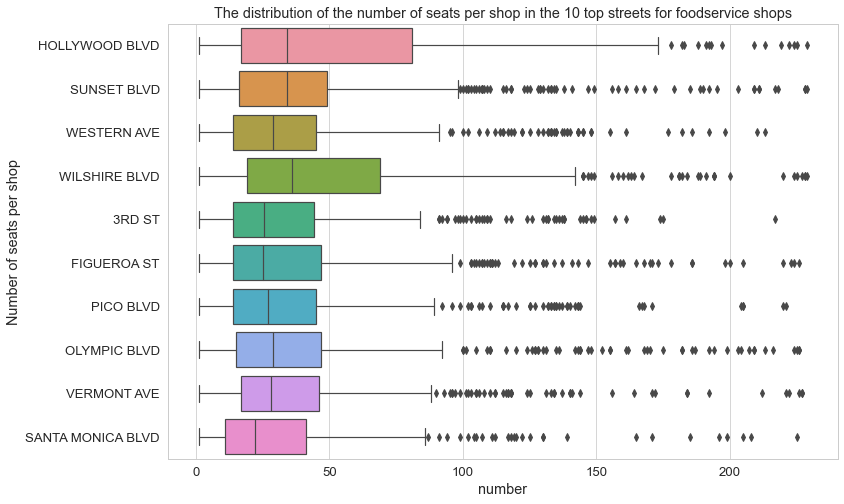

In [55]:
# A boxplot illustrating the seat distribution in the 5 top streets:
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1}, palette="Set2")
sns.set_context("paper", font_scale=1.5)                                                  
ax= sns.boxplot(x='number', y='street_name', data=df_top10)

plt.title("The distribution of the number of seats per shop in the 10 top streets for foodservice shops")
plt.ylabel("Number of seats per shop");

**- The boxplot plot shows the distributions of seat numbers in foddservice shops of each of the 10 streets chosen. It seems that in most streets the majority of the shops offer between 15-47 seats, with median values of 10-35, and max value of 229. 
The seat distributions of Wilshire BLVD's shops and of Hollywood Blvd's shops stand out, having much wider interquartile ranges (IQR) and longer upper whiskers as well. Their median value is somewhat higher too.  Santa Monica Blvd, has a somewhat lower number of seats, reflected in a lower median, a narrower IQR and shorter whiskers. Outlier values are observed in all streets, stretching towards the upper side of the axis**

In [56]:
# preparing data for a bar plot with average number of seats included:
df_top10_2 = df_top10[['object_type', 'number','street_name']].groupby(['street_name', 'object_type']).agg({'number':['mean', 'count']}).reset_index()
df_top10_2.columns=['street_name', 'foodservice_type', 'avg_seats', 'num_shops']
df_top10_2['percent_shops'] = 100* (round(df_top10_2['num_shops'] / df_top10_2.groupby('street_name')['num_shops'].transform('sum'), 2))
df_top10_2.head()


,street_name,foodservice_type,avg_seats,num_shops,percent_shops
0,3RD ST,Bakery,41.090909,11,4.0
1,3RD ST,Bar,19.600000,5,2.0
2,3RD ST,Cafe,19.846154,13,5.0
3,3RD ST,Fast Food,39.352941,17,7.0
4,3RD ST,Pizza,24.750000,8,3.0


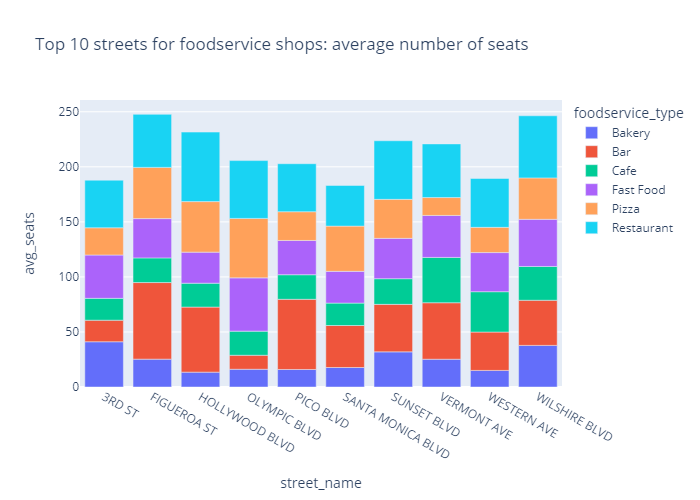

<Figure size 864x576 with 0 Axes>

In [57]:
                                                 
plt.figure(figsize=(12, 8))  
fig=px.bar(
    df_top10_2, x="street_name", y="avg_seats", color='foodservice_type', title='Top 10 streets for foodservice shops: average number of seats',
    hover_data=['num_shops', 'percent_shops'],
)
fig.show("png");
    



**The bar plots adds info about the general availability (mean) of seats according to both- street and the type of foodservice.
- As can be seen, in each street the distribution of the mean number of seats varies between the different foodservice type. For example: In Figueroa and Pico, the greatest number of seats are found in bars (maybe that's a good place for night-life activities), whereas in Sunset, Western and Wilshire the greatest amount of seats are found in restaurants. (It could be interesting to have data on peak hours of activity)
- The order of seats per street does not correlate with the order of the number of shops per streets. Figueroa St., for example, has the lowest number of shops, but the highest number of seats.
Focusing on Cafes: 
- Seats: Vermont and Western ave. offer the largest amount of seats compared to other streets (41 and 37, respectively), while 3rd St. and Santa Monica Blvd.'s coffee shops offer on average the lowest number of seats (19-20). Most cafes offer around 22 seats. 
- Number of coffee shops: Sunset Blvd. and Wilshire Blvd. hold (by far) the highest amount of coffee shops (28 and 25, respectively). This might indicate that these streets are not the best option for openning a new cafe. Most streets have between 7-13 coffee shops.
- Percentage of cafes in each street: In each street the coffee shops inhabit between 2%-7% of all the foodservice types, with a general average of 4.5% (see pie plot in section 1.2). This might mean that streets in which the number of cafes is only 2% or 3% are not saturated and there is room to grow (Vermont, Western and Figueroa).


## 3. Conclusions:


This project's aim was to assist decision makers regarding the opening of a small robot-run cafe in Los Angeles, by preparing market research. In order to attract investors, we are interested in providing a clear picture about the current market conditions- specifically: The distribution of foodservice shops across different types of foodservices, as well as across different streets in the city. Also, we would like to know more about the distribution of chain and non-chain shops, and the number of seats in each establishment. 
Relevant data was extracted from open-source data on restaurants in LA.

**Research included 2 stages:**
-	Preprocessing data (dealing with missing values, looking for duplicates and changing data types).
-	Data analysis: focusing on the distribution of shops and number of seats, across different streets, foodservice type and comparing chains to non-chain shops.

**Preprocessing:** 
After dropping 3 rows with missing values, we were left with 9648 data rows of foodservice shops in Los Angeles. No duplicates were identified.

**Data Analysis:**
##### General distribution of foodservice type:
The most popular foodservice type was a restaurant (75.18%), in a big gap from fast food (11.05%), Café (4.51%), Pizza- why isn't it fast food too.. (3.31%), bar (3.03%) and bakeries (2.93%).


##### General distribution of shops that are part of a chain:
- 61.9% of foodservice shops were found to belong to a chain (38.1%- non-chains). 
- Chain foodservice businesses tended to offer less seating options, compared with businesses that were not part of a chain.

##### The division of shops between chain/non-chain depended on the foodservice type: 
•	Bars, restaurants and Pizza joints had a higher chance of being non-chain establishment (74% , 68% and 52% non chains, respectively).
•	Bakeries, Cafe shops and fast food joints, on the other hand, were more often part of a chain (100%, 61% and 57%, respectively).

##### General number of seats:

- On average, restaurants and bars offer above average seating options, whereas fast food, pizza joints, cafe shops and bakeries offered the smallest amount (in this order). Maybe LA has a richer night than day life, in terms of foodservices, or maybe averaging data from the whole city, masks different dynamics in different neighborhoods 
- There were 186 businesses that offered only one seated customer (maybe a take away place..?), and they were from all foodservice types and chain.

##### Distribution across different streets:

- The top 10 street, in terms of the number of foodservice shops, had between 250 and 403 shops.
- There were 250 streets that have only ONE foodservice shop.

- Looking closer into the more crowded streets:
 - - The majority of foodservice shops offer between 15-47 seats, with median values of 10-35, and max value of 229. 
 - - The seat distributions of Wilshire BLVD's shops and of Hollywood Blvd's shops stand out, having much wider interquartile ranges (IQR) and longer upper whiskers as well. Their median value is somewhat higher too.
 - - Santa Monica Blvd, has a somewhat lower number of seats, reflected in a lower median, a narrower IQR and shorter whiskers.
 - - Outlier values are observed in all streets, stretching towards the upper side of the axis.

##### Street and seats interaction:
- In each street the distribution of the mean number of seats varied between the different foodservice type. 
- For example: In Figueroa and Pico, the greatest number of seats were found in bars (maybe that's a good place for night-life activities), whereas in Sunset, Western and Wilshire the greatest number of seats were found in restaurants.

##### Street, seat and number of shops:

- The order of seats per street did not correlate with the order of the number of shops per streets. 
- Figueroa St., for example, has the lowest number of shops, but the highest number of seats.

##### Street, seat, foodservice type and number of shops:

- In general, the number of shops for each foodservice type and the average number of seats per foodservice type tended to vary between streets. 
- This implies that each street has its own characteristics that are reflected in the specific mixture of foodservices offered.

**Focusing on Cafes:** 
- Seats: Vermont and Western ave. offer the largest amount of seats compared to other streets (41 and 37, respectively), while 3rd St. and Santa Monica Blvd.'s coffee shops offer on average the lowest number of seats (19-20). Most cafes offer around 22 seats. 
- Number of coffee shops: Sunset Blvd. and Wilshire Blvd. hold (by far) the highest amount of coffee shops (28 and 25, respectively). This might indicate that these streets are not the best option for opening a new cafe. Most streets have between 7-13 coffee shops.
- Percentage of cafes in each street: In each street the coffee shops inhabit between 2%-7% of all the foodservice types, with a general average of 4.5% (see pie plot in section 1.2). This might mean that streets in which the number of cafes is only 2% or 3% are not saturated and there is room to grow (Vermont, Western and Figueroa).

**Recommendations:**
-	1- According to this short research, it seems that a lot of the streets are not fully saturated yet, and there is room for an innovative Café, as we offer. We would suggest choosing busy areas, that are not saturated already with coffee shops (around 2-3% of the total foodservices in the street).  
-	2- We suggest studying deeper the characteristics of cafés customers, in different locations in the city: looking into ages and peak hours. We assume that a robo-café would be best tested in a young and vibrant area, such as a high tech or university area, where people are more apt to trying technological solutions.
-	3- Location wise, Since a lot of the crowded and busy streets are very long Blvd and Ave, it would be a good idea, once we choose a general location, to study the different parts of the designated street (or.. not to research by street name, but by area).
-	5- Cafés tend to offer around 25 seats per shop, so we suggest to follow the same custom. We should find out how common the take away option is, and maybe locate the robot kitchen in a more visible place for customers to see.
-	6- Most of the coffee shops are part of chains, so it might be wise to aim for it as well.
-	7- It is advisable to look into the financial aspects of starting a business, as well as to explore the seasonal aspects of living in a highly touristic and industrial city like LA. 



#### A link to the powerpoint presentation:
https://drive.google.com/file/d/1AwNtUFEsrZFGEvUKT_3EihLCpcEOwise/view?usp=sharing